In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import h5py
import numpy as np
import random
import cv2
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input, Lambda, Activation, Concatenate, Add, Dropout
from tensorflow.python.keras.layers import BatchNormalization, Conv2D, DepthwiseConv2D, ZeroPadding2D
from tensorflow.python.keras.layers import GlobalAveragePooling2D
from tensorflow.python.keras.utils.layer_utils import get_source_inputs
from tensorflow.python.keras.activations import relu
from tensorflow.python.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence, to_categorical
import os
from PIL import Image
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive/')
drivloc ="/content/drive/My Drive/deeplabv3/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Utility methods to process CityScape data

In [0]:
def get_files(folder, name_filter=None, extension_filter=None):

    if not os.path.isdir(folder):
        raise RuntimeError("\"{0}\" is not a folder.".format(folder))

    if name_filter is None:
        name_cond = lambda filename: True
    else:
        name_cond = lambda filename: name_filter in filename

    if extension_filter is None:
        ext_cond = lambda filename: True
    else:
        ext_cond = lambda filename: filename.endswith(extension_filter)

    filtered_files = []
    for path, _, files in os.walk(folder):
        files.sort()
        for file in files:
            if name_cond(file) and ext_cond(file):
                full_path = os.path.join(path, file)
                filtered_files.append(full_path)

    return filtered_files


def pil_loader(data_path, label_path, shape):
    data = Image.open(data_path)
    label = Image.open(label_path)
    return np.array(data), np.array(label)


def remap(image, old_values, new_values):
    k_img = np.zeros_like(image)
    for old, new in zip(old_values, new_values):
        if new != 0:
          k_img[image == old] = new

    # print(np.unique(resized_image))
    return k_img

In [0]:
def get_cs_data_set(test_folder, test_lbl_folder):
  # Filters to find the images
  img_extension = '.png'
  lbl_name_filter = 'labelIds'

  # The values associated with the 35 classes
  full_classes = (
      0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
      20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, -1
  )
  # The values above are remapped to the following
  # new_classes = (
  #     0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 3, 4, 5, 0, 0, 0, 6, 0, 7, 8, 9, 10,
  #     11, 12, 13, 14, 15, 16, 0, 0, 17, 18, 19, 0
  # )

  new_classes = (
      0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 2, 3, 9, 0, 0, 0, 5, 0, 6, 7, 8, 11,
      10, 12, 15, 13, 14, 16, 0, 0, 17, 0, 18, 0
  )

  # Get the test data and labels filepaths
  test_images = get_files(test_folder,
      extension_filter=img_extension
  )

  test_labels = get_files(test_lbl_folder,
      name_filter=lbl_name_filter,
      extension_filter=img_extension
  )

  # Initialize image_batch and label_batch if needed
  image_batch = np.empty(
      (len(test_images), ) + (1024, 2048, 3)
  )
  label_batch = np.empty(
      (len(test_images), ) + (1024, 2048)
  )

  for idx, image_path in enumerate(test_images):
              image, label = pil_loader(
                  image_path,
                  test_labels[idx],
                  (2048, 1024),
              )
              # PIL to numpy
              image = np.asarray(image)
              label = np.asarray(label)

              image_batch[idx] = image
              label_batch[idx] = label

  # Remap class labels
  label_batch_mapped = remap(label_batch, full_classes, new_classes)

  return image_batch, label_batch_mapped


def resize_image_set(image_batch, w, h, trained_image_width = 512):

  ratio = float(trained_image_width) / np.max([w, h])
  image_batch_rs = []
  for id in range(image_batch.shape[0]):
    image_batch_rs.append(np.array(Image.fromarray(image_batch[id].astype('uint8')).resize((int(ratio * h), int(ratio * w)))))

  return np.asarray(image_batch_rs)

In [0]:
def _mean_iou(y_true, y_pred, num_classes):

        target = np.ravel(y_true[18])
        predicted = np.ravel(y_pred[18])

        x = predicted + num_classes * target
        bincount_2d = np.bincount(
            x.astype(np.int32), minlength=num_classes**2
        )
        assert bincount_2d.size == num_classes**2
        conf = bincount_2d.reshape(
            (num_classes, num_classes)
        )

        true_positive = np.diag(conf)
        false_positive = np.sum(conf, 0) - true_positive
        false_negative = np.sum(conf, 1) - true_positive

        with np.errstate(divide='ignore', invalid='ignore'):
            iou = true_positive / (true_positive + false_positive + false_negative)
        iou[np.isnan(iou)] = 1

        return np.mean(iou).astype(np.float32)

### Deeplab Model using MobileNetv2 backbone

In [0]:
def relu6(x):
    return relu(x, max_value=6)


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs.shape[-1].value  # inputs._keras_shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    if block_id:
        # Expand

        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',
                   use_bias=False, activation=None,
                   name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                               name=prefix + 'expand_BN')(x)
        x = Activation(relu6, name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                        use_bias=False, padding='same', dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'depthwise_BN')(x)

    x = Activation(relu6, name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters,
               kernel_size=1, padding='same', use_bias=False, activation=None,
               name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'project_BN')(x)

    if skip_connection:
        return Add(name=prefix + 'add')([inputs, x])

    return x


def Deeplabv3(input_shape=(256, 512, 3), classes=19, alpha=1.):

    img_input = Input(shape=input_shape)


    OS = 8
    first_block_filters = _make_divisible(32 * alpha, 8)
    x = Conv2D(first_block_filters,
                kernel_size=3,
                strides=(2, 2), padding='same',
                use_bias=False, name='Conv')(img_input)
    x = BatchNormalization(
        epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
    x = Activation(relu6, name='Conv_Relu6')(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1, expansion=1, block_id=0, skip_connection=False)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2, expansion=6, block_id=1, skip_connection=False)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1, expansion=6, block_id=2, skip_connection=True)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=3, skip_connection=False)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=4, skip_connection=True)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=5, skip_connection=True)

    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=6, skip_connection=False)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2, expansion=6, block_id=7, skip_connection=True)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2, expansion=6, block_id=8, skip_connection=True)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2, expansion=6, block_id=9, skip_connection=True)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2, expansion=6, block_id=10, skip_connection=False)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2, expansion=6, block_id=11, skip_connection=True)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2, expansion=6, block_id=12, skip_connection=True)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2, expansion=6, block_id=13, skip_connection=False)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4, expansion=6, block_id=14, skip_connection=True)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4, expansion=6, block_id=15, skip_connection=True)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4, expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

    # Image Feature branch
    shape_before = tf.shape(x)
    b4 = GlobalAveragePooling2D()(x)
    # from (b_size, channels)->(b_size, 1, 1, channels)
    b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
    b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
    b4 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation('relu')(b4)
    
    # upsample. have to use compat because of the option align_corners
    size_before = tf.keras.backend.int_shape(x)
    b4 = Lambda(lambda x: tf.compat.v1.image.resize(x, size_before[1:3],
                                                    method='bilinear', align_corners=True))(b4)
    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation('relu', name='aspp0_activation')(b0)

    x = Concatenate()([b4, b0])

    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)
    # DeepLab v.3+ decoder

    last_layer_name = 'logits_semantic'

    x = Conv2D(classes, (1, 1), padding='same', name=last_layer_name)(x)
    size_before3 = tf.keras.backend.int_shape(img_input)
    x = Lambda(lambda xx: tf.compat.v1.image.resize(xx,
                                                    size_before3[1:3],
                                                    method='bilinear', align_corners=True))(x)

    
    inputs = img_input

    model = Model(inputs, x, name='deeplabv3plus')

    return model

def preprocess_input(x):
    return preprocess_input(x, mode='tf')


## Prepare training data

In [0]:
should_train = False

train_folder = drivloc + "images/train_data/lindau"
train_lbl_folder = drivloc + "images/train_label/lindau"

if should_train:
  train_x_data, train_y_data = get_cs_data_set(train_folder, train_lbl_folder)
  _, h, w, __ = train_x_data.shape
  train_x_resized_data = resize_image_set(train_x_data, h, w)

  train_x_data = (train_x_resized_data / 127.5) - 1.

  train_y_data = resize_image_set(train_y_data, h, w)
  train_y_data = to_categorical(train_y_data, 19)

### Create and train Model

In [8]:
deeplab_model = Deeplabv3()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
deeplab_model.load_weights(drivloc + 'weights/model.h5', by_name=True)

if should_train:
  deeplab_model.compile(optimizer=SGD(lr=0.007, decay=1e-6, momentum=0.9, nesterov=True),
                    loss='categorical_crossentropy')
  TRAIN_BATCH =5
  VAL_BATCH = 2

  # deeplab_model.fit(x=train_x_data, y=train_y_data, batch_size=5, epochs=10, verbose=1, 
  #                   validation_split=0.1, shuffle=True)

  # deeplab_model.train_on_batch(train_x_data, train_y_data)
  # pretained weights has been loaded from tensorflow deeplab


  epochs = 100
  for e in range(epochs + 1):
      for i in range(len(train_x_data) // TRAIN_BATCH):
          X_batch = train_x_data[i*TRAIN_BATCH:(i+1)*TRAIN_BATCH]
          Y_batch = train_y_data[i*TRAIN_BATCH:(i+1)*TRAIN_BATCH]
          deeplab_model.train_on_batch(x=X_batch,y=Y_batch)
          print('epoch:' +str(e) +' batch:' +str(i)) 

# Test Performance

In [0]:
# Test dataset root folders
test_folder = drivloc + "images/test_data/lindau"
test_lbl_folder = drivloc + "images/test_label/lindau"


x_data, y_data = get_cs_data_set(test_folder, test_lbl_folder)


In [11]:
print(x_data.shape)
print(y_data.shape)

(59, 1024, 2048, 3)
(59, 1024, 2048)


In [12]:
_, h, w, __ = x_data.shape
x_resized_data = resize_image_set(x_data, h, w)

mean_subtraction_value=127.5
x_resized_data = (x_resized_data / mean_subtraction_value) - 1.

y_true_data = resize_image_set(y_data, h, w)

y_data_cat = to_categorical(y_true_data, 19)
print(x_resized_data.shape)
print(y_true_data.shape)

(59, 256, 512, 3)
(59, 256, 512)


In [0]:
preds = deeplab_model.predict(x_resized_data)
y_predict_data = np.argmax(preds.squeeze(), -1)

In [14]:
print(_mean_iou(y_true_data,y_predict_data,21))

0.57472056


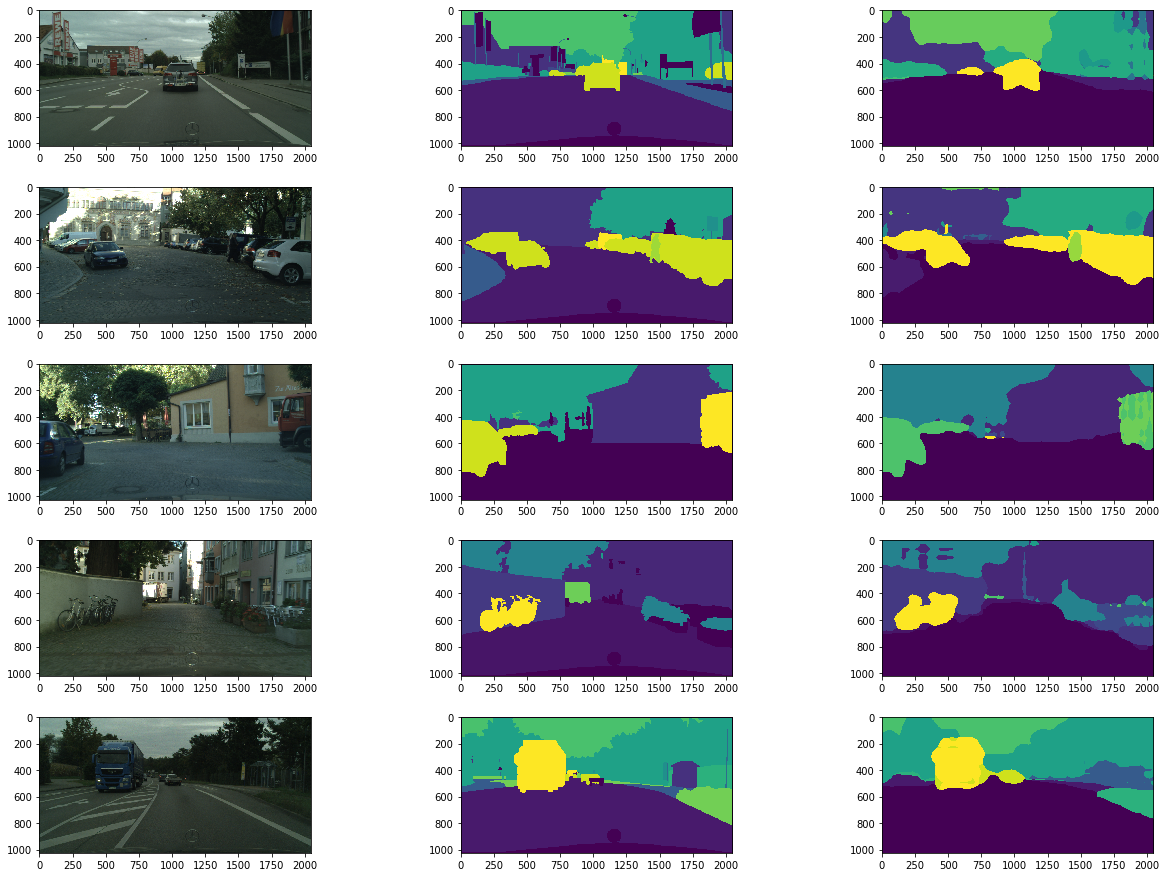

In [15]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

fig = plt.figure(figsize=(26,13))
gs = gridspec.GridSpec(5, 3, width_ratios=[1, 1, 1],
         wspace=0.0, hspace=0.3, top=0.95, bottom=0.05, left=0.17, right=0.845) 
# f, axarr = plt.subplots(5,3,figsize=(26,13))
id =0
for i in np.random.choice(40, 5, replace=False):
  ori = np.array(Image.fromarray(x_data[i].astype('uint8')).resize((w, h)))
  target = np.array(Image.fromarray(y_true_data[i].astype('uint8')).resize((w, h)))
  pred = np.array(Image.fromarray(y_predict_data[i].astype('uint8')).resize((w, h)))

  ax= plt.subplot(gs[id,0])
  ax.imshow(ori)

  ax= plt.subplot(gs[id,1])
  ax.imshow(target)

  ax= plt.subplot(gs[id,2])
  ax.imshow(pred)

  id = id +1


## Reference

https://towardsdatascience.com/the-evolution-of-deeplab-for-semantic-segmentation-95082b025571

https://towardsdatascience.com/review-deeplabv3-atrous-convolution-semantic-segmentation-6d818bfd1d74

https://arxiv.org/abs/1606.00915

https://arxiv.org/pdf/1802.02611.pdf

https://www.kaggle.com/alexanderliao/deeplabv3

https://github.com/bonlime/keras-deeplab-v3-plus

https://github.com/tensorflow/models/tree/master/research/deeplab

https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/cityscapes.md

https://github.com/Golbstein/Keras-segmentation-deeplab-v3.1/

https://github.com/JonathanCMitchell/mobilenet_v2_keras

https://github.com/dhkim0225/keras-image-segmentation

https://github.com/davidtvs/Keras-LinkNet

https://www.analyticsvidhya.com/blog/2019/02/tutorial-semantic-segmentation-google-deeplab/

(256, 512, 3)


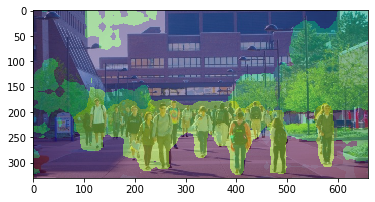

In [16]:
trained_image_width=512
trained_image_height=256 
mean_subtraction_value=127.5
image = np.array(Image.open(drivloc + 'images/ub.jpg'))

# resize to max dimension of images from training dataset
w, h, _ = image.shape
ratio = float(trained_image_width) / np.max([w, h])
resized_image = np.array(Image.fromarray(image.astype('uint8')).resize((int(ratio * h), int(ratio * w))))

resized_image = (resized_image / mean_subtraction_value) - 1.

print(resized_image.shape)
res = deeplab_model.predict(np.expand_dims(resized_image, 0))
labels = np.argmax(res.squeeze(), -1)

labels = np.array(Image.fromarray(labels.astype('uint8')).resize((h, w)))

plt.imshow(labels,interpolation='none') 
plt.imshow(image, cmap='jet', interpolation='none', alpha=0.5)